In [1]:
!pip install ucimlrepo
!pip install ydata-profiling
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets

In [3]:
df = pd.DataFrame(
    bank_marketing.data.features,
    columns=bank_marketing.data.feature_names)
df["y"] = y
print(df.dtypes)

age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object


In [4]:
display(df.select_dtypes(include='object').describe())

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,44923,45211,43354,45211,45211,45211,32191,45211,8252,45211
unique,11,3,3,2,2,2,2,12,3,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,failure,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,4901,39922


In [5]:
print(df.dtypes)
print(df.isna().sum())

age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64


In [6]:
#uzupełnianie brakujących wartości job i education
columns_with_unknown = ['job', 'education']

for col in columns_with_unknown:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

columns_with_nan = ['contact', 'poutcome']

for col in columns_with_nan:
    df[col] = df[col].fillna('unknown')

In [7]:
#zmiana kolumn yes-no na 1-0
binary_col = ['default', 'housing', 'loan', 'y']
for col in binary_col:
    df[col] = df[col].map({'yes': 1, 'no': 0})

In [ ]:
profile = ProfileReport(df,title="Profil Danych Bankowych")
profile.to_file("bank_marketing_profile.html")
#Można pobrać z plików stronę z wykresami

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:02<00:00,  6.63it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
#zrobienie z pdays i previous jednej kolumny z uwagi na bardzo wysoką korelacje (ta sama informacja)
df["pcontact"] = (df["pdays"] > 0).astype(int)
df.drop(["pdays" , "previous"], axis=1, inplace=True)

In [9]:
#pozbycie się outlierów poprzez capping
numerical_cols = ['age', 'balance', 'duration']

for col in numerical_cols:
    Q1 = df[col].quantile(0.1)
    Q3 = df[col].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers instead of removing rows
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [10]:
y_counts = y["y"].value_counts()
x_counts = X["housing"].value_counts()
print(y_counts)
print(x_counts)

y
no     39922
yes     5289
Name: count, dtype: int64
housing
yes    25130
no     20081
Name: count, dtype: int64


In [11]:
#onehotencoding kategorycznych kolumn
categorical_cols = df.select_dtypes(include='object').columns

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [12]:
df.drop(["y"], axis=1, inplace=True)
y['y'] = y['y'].map({'yes': 1, 'no': 0})

/tmp/ipython-input-1427517253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['y'] = y['y'].map({'yes': 1, 'no': 0})


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

scaler = StandardScaler()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=420)

y_aligned = y.loc[df.index]

for train_index, test_index in split.split(df, y_aligned):
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = y_aligned.iloc[train_index], y_aligned.iloc[test_index]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
# ros = RandomOverSampler(random_state=420)
# X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

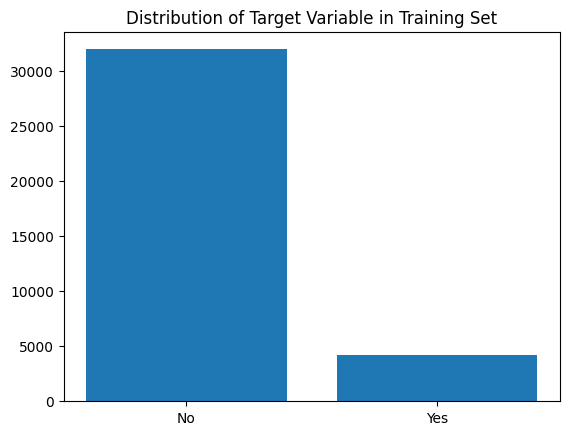

In [ ]:
counts = np.bincount(y_train['y'])
positions = np.arange(len(counts))
plt.bar(positions, counts)
plt.title('Distribution of Target Variable in Training Set')
plt.xticks(positions, ['No', 'Yes'])
plt.show()

In [ ]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

linear = linear_model.LogisticRegression(class_weight="balanced", random_state=420)

param_grid_linear = {
    'C': [1, 0.1, 0.01],
    'max_iter': [1000,500]
}
grid = GridSearchCV(linear, param_grid_linear, cv=4)

grid.fit(X_train_scaled, y_train)

best_linear = grid.best_estimator_

best_linear.fit(X_train_scaled, y_train)

y_predlin = best_linear.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_predlin)
precision = precision_score(y_test, y_predlin)
recall = recall_score(y_test, y_predlin)
f1 = f1_score(y_test, y_predlin)

print("Accuracy linear:", accuracy)
print("Precision linear:", precision)
print("Recall linear:", recall)
print("F1 Score linear:", f1)


knn = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors": [2, 4],
    "weights": ["uniform", "distance"]
}
gridknn = GridSearchCV(knn, param_grid_knn, cv=4)

gridknn.fit(X_train_scaled, y_train)

best_knn = gridknn.best_estimator_

best_knn.fit(X_train_scaled, y_train)

y_predknn = best_knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_predknn)
precision = precision_score(y_test, y_predknn)
recall = recall_score(y_test, y_predknn)
f1 = f1_score(y_test, y_predknn)

print("Accuracy knn:", accuracy)
print("Precision knn:", precision)
print("Recall knn:", recall)
print("F1 Score knn:", f1)

svc = LinearSVC(class_weight="balanced", random_state=420)

param_grid_linearsvc = {
    'C': [1, 0.1],
    'penalty': ["l1", "l2"]
}

gridsvc = GridSearchCV(svc, param_grid_linearsvc, cv=4)
gridsvc.fit(X_train_scaled, y_train)

best_svc = gridsvc.best_estimator_
best_svc.fit(X_train_scaled, y_train)

y_predsvc = best_svc.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_predsvc)
precision = precision_score(y_test, y_predsvc)
recall = recall_score(y_test, y_predsvc)
f1 = f1_score(y_test, y_predsvc)

print("Accuracy svc:", accuracy)
print("Precision svc:", precision)
print("Recall svc:", recall)
print("F1 Score svc:", f1)

Accuracy linear: 0.8434147959747871
Precision linear: 0.4154863078375826
Recall linear: 0.831758034026465
F1 Score linear: 0.5541561712846348
Accuracy knn: 0.8949463673559659
Precision knn: 0.6330049261083743
Recall knn: 0.24291115311909262
F1 Score knn: 0.3510928961748634


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy svc: 0.8468428618821188
Precision svc: 0.4211287988422576
Recall svc: 0.8251417769376181
F1 Score svc: 0.5576493133184286


In [ ]:
import shap

explainer = shap.LinearExplainer(best_linear, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

In [ ]:
y_pred = best_linear.predict(X_test_scaled)

correct_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred == actual]

incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred != actual]

correct_example_index = correct_indices[0] if correct_indices else None
incorrect_example_index = incorrect_indices[0] if incorrect_indices else None

if correct_example_index is not None:
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[correct_example_index], X_test_scaled[correct_example_index])

if incorrect_example_index is not None:
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[incorrect_example_index], X_test_scaled[incorrect_example_index])


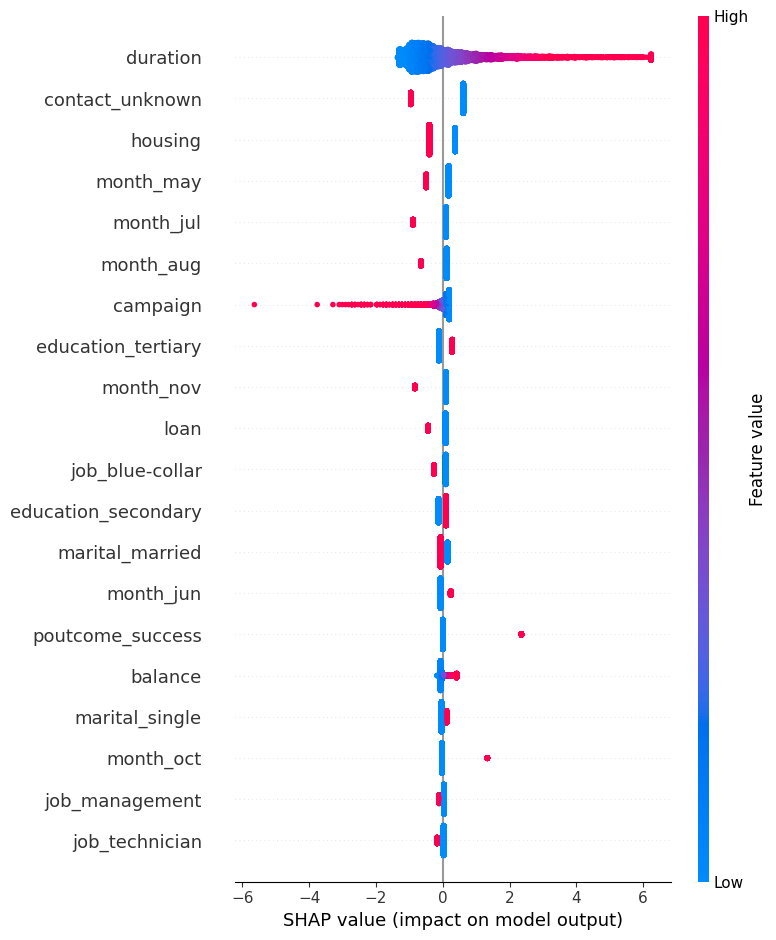

In [ ]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=df.columns)


# Wnioski

W kolumnach 'zawód' i 'wykształcenie' brakowało kilku wpisów, więc uzupełniłem je najczęściej występującymi wartościami.

W części dotyczącej kontaktu oraz wyniku poprzedniego kontaktu było wiele pustych miejsc, dlatego też w tych miejscach wpisałem po prostu, że są one nieznane.

Tam, gdzie było “tak” lub “nie", na przykład czy ktoś ma kredyt mieszkaniowy, czy wziął lokatę, zmieniłem to na “1” i “0", ponieważ komputer lepiej rozumie takie oznaczenia.

Zauważyłem, że kolumny 'liczba dni od ostatniego kontaktu' i 'liczba wcześniejszych kontaktów' w zasadzie mówiły to samo. Więc stworzyłem jedną nową kolumnę, która mówi po prostu, czy był jakiś wcześniejszy kontakt, a tamte dwie usunąłem, żeby nie dublować informacji.

W niektórych kolumnach (wiek, saldo, czas trwania) były wartości, które mocno odbiegały od reszty. Zamiast je usuwać, "ograniczyłem" je, czyli jeśli coś było bardzo, bardzo małe, to ustawiałem na dolną granicę, a jak bardzo duże, to na górną. Dzięki temu nie tracę danych, a model lepiej sobie radzi.

Okazało się, że większość ludzi nie wybrała lokaty terminowej. Było prawie 40 tysięcy osób, które powiedziały “nie", w porównaniu z 5 tysiącami, które powiedziały “tak". To jest pewnego rodzaju problem, ponieważ model mógłby nauczyć się tylko mówić “nie". Rozwiązałem ten problem, nadając większą wagę do przypadków, w których ludzie powiedzieli “tak", podczas szkolenia modelu.

Wszystkie te kategorie, jak na przykład zawód, miesiąc lub kontakt, musiałem przekształcić w liczby, aby model mógł je wykorzystać. Dokonałem tego, tworząc z każdej kategorii kilka nowych kolumn zawierających '1' lub '0'.

Stworzyłem również automatyczny raport szczegółowy w formacie HTML. Ten raport zawiera wszystkie informacje o danych, w tym ich rozmieszczenie, powiązania między nimi oraz ewentualne problemy. Jest to swojego rodzaju kompleksowa historia moich danych, pokazująca wszystko, co się na nie składa.

Mam nadzięję, że tym razem wygląda to lepiej niż poprzednio :)